In [1]:
from collections import namedtuple
from decimal import Decimal as D
import numpy as np
import scipy as sp
import datetime

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
%pylab inline
%config InlineBackend.figure_format='retina'

Populating the interactive namespace from numpy and matplotlib


/Users/ben/.virtualenvs/personal/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


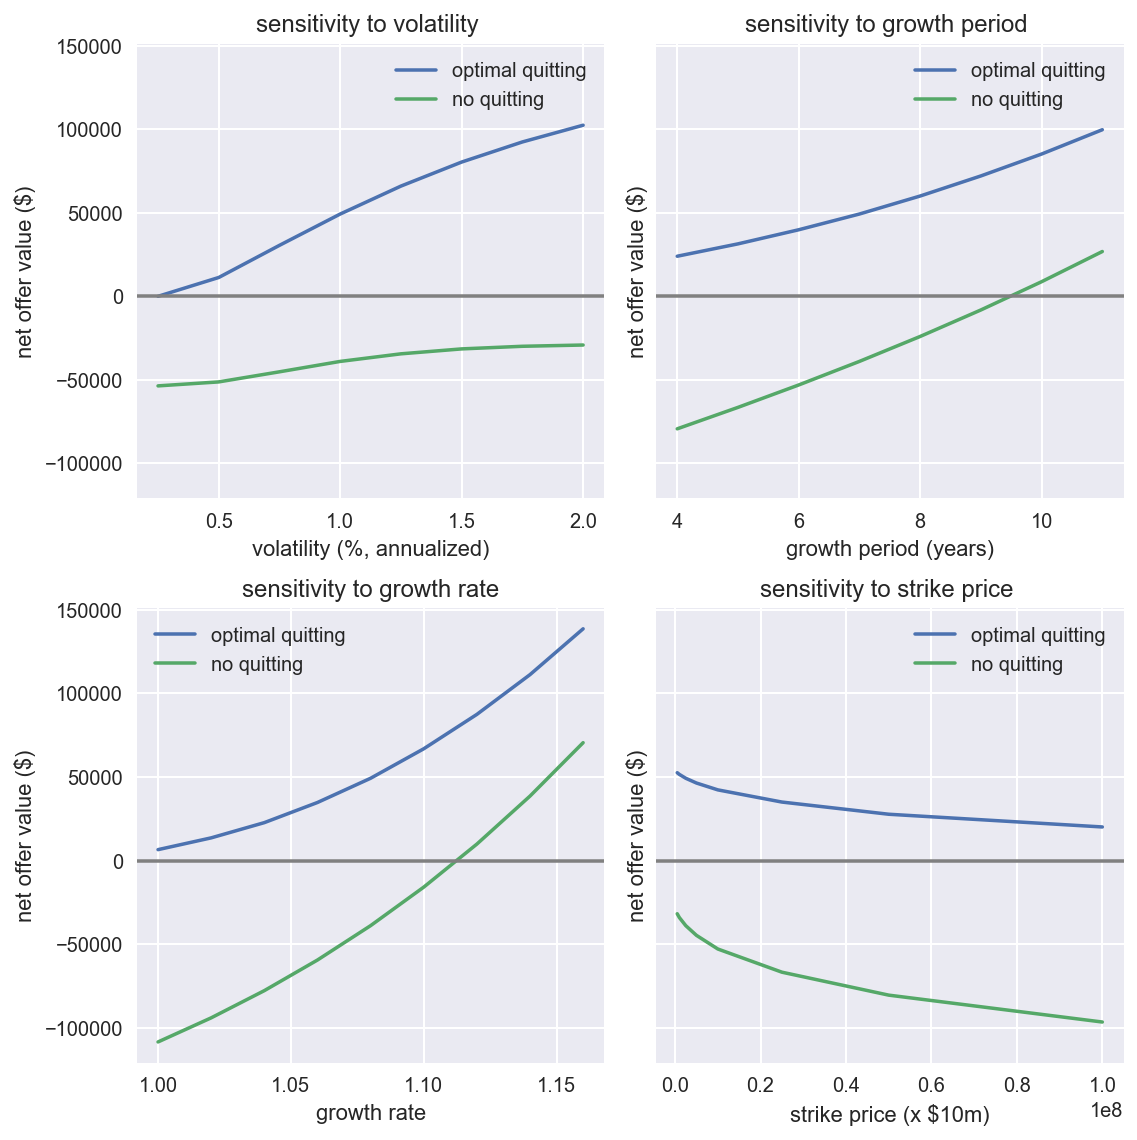

In [3]:
def plot_series(name, xlabel=None):
    data = pd.read_csv('%s.csv' % name)
    plt.plot(data[name], data.fixed_horizon, label='optimal quitting')
    plt.plot(data[name], data.naive, label='no quitting')
    xlabel = xlabel or name.replace('_', ' ')
    plt.xlabel(xlabel)
    plt.title('sensitivity to ' + xlabel.split('(')[0])
    plt.ylabel('net offer value ($)')
    plt.legend()
    plt.axhline(0, color='gray')

plt.figure(figsize=(8, 8))

PV = 2
PH = 2

ax1 = plt.subplot(PV, PH, 1)
## annual volatility
plot_series('annual_volatility', xlabel='volatility (%, annualized)')

## growth period
ax = plt.subplot(PV, PH, 2, sharey=ax1)
plt.setp(ax.get_yticklabels(), visible=False)
plot_series('horizon_years', xlabel='growth period (years)')

## growth rate
ax = plt.subplot(PV, PH, 3, sharey=ax1)
plot_series('annual_growth', xlabel='growth rate')

## strike price
ax = plt.subplot(PV, PH, 4, sharey=ax1)
plt.setp(ax.get_yticklabels(), visible=False)
plot_series('strike_price', xlabel='strike price (x $10m)')

plt.tight_layout()

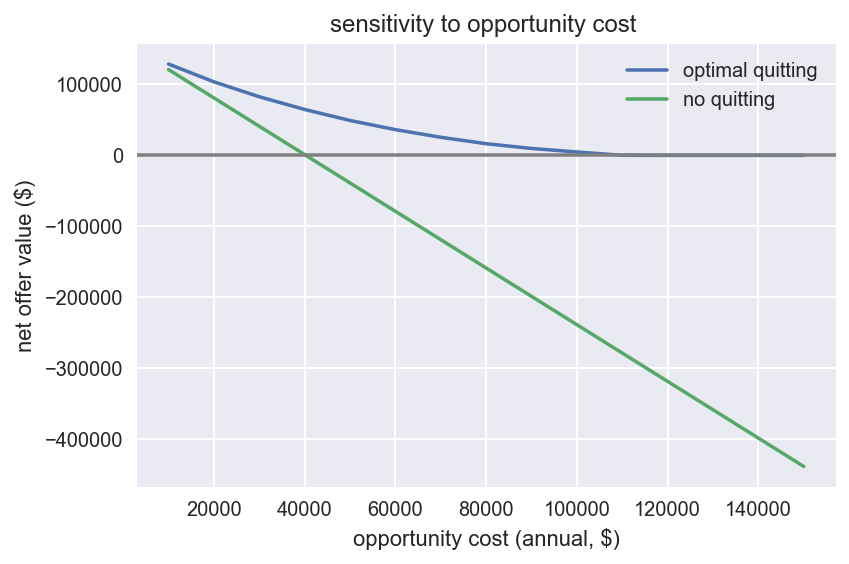

In [4]:
plot_series('opportunity_cost', xlabel='opportunity cost (annual, $)')
plt.tight_layout()

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import options
params = dict(options.COMMON_PARAMS)
params['annual_timesteps'] = 36
model = options.FixedHorizonModel(**params)

In [7]:
## get the data
indices = [options.I(t, n_up) for t in range(model.ts_horizon+1) for n_up in range(t+1)]
df = pd.DataFrame(columns=['t', 'n_up', 'p', 'val', 'quit', 'p_quit_by_now'], index=range(len(indices)))
print(df.loc[0])
for n, i in enumerate(indices):
    should_quit = (i.t > model.ts_vesting_interval
                   or model.get_payoff(i, i.t) >= model.get_payoff(i))
    df.loc[n] = (i.t, i.n_up, model.get_p_n_up(i), model.get_valuation(i),
                 should_quit, model.p_quit_before_or_at(i))

t                NaN
n_up             NaN
p                NaN
val              NaN
quit             NaN
p_quit_by_now    NaN
Name: 0, dtype: object


In [8]:
df[df.t == 4]

,t,n_up,p,val,quit,p_quit_by_now
10,4,0,0.082035,5.13417e+06,False,0
11,4,1,0.285,7.16531e+06,False,0
12,4,2,0.371296,1e+07,False,0
13,4,3,0.214988,1.39561e+07,False,0
14,4,4,0.046681,1.94773e+07,False,0


In [9]:
p_quit = pd.Series(index=range(model.ts_horizon+1))
for n in p_quit.index:
    df_for_n = df[df.t == n]
    p_quit[n] = (df_for_n.p * df_for_n.p_quit_by_now).sum()

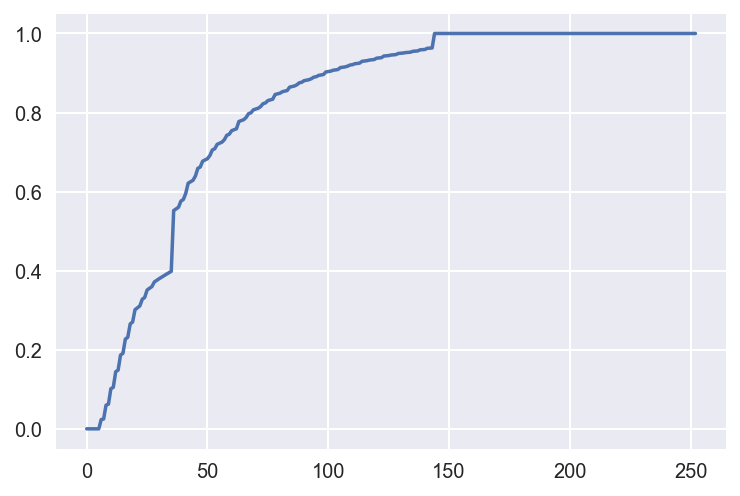

In [10]:
plt.plot(p_quit.index, p_quit)

In [11]:
stay_valuation = pd.Series(index=p_quit.index)
for t in range(model.ts_vesting_interval):
    if model.get_payoff(options.I(t, 0), t) < model.get_payoff(options.I(t, 0)):
        # should never quit at this timestep
        continue
    for n_up in range(1, t+1):
        i = options.I(t, n_up)
        if model.get_payoff(i, t) < model.get_payoff(i):
            stay_valuation[t] = model.get_valuation(i)
            break

In [12]:
import numpy as np
import math

In [13]:
LOG_Y_MIN = 1
LOG_Y_MAX = 11
df_clean = df[(df.val > 10 ** LOG_Y_MIN) & (df.val < 10 ** LOG_Y_MAX)].copy()
for t in range(model.ts_horizon+1):
    ps = df_clean.p[df_clean.t == t]
    pmax = ps.max()
    for i in ps.index:
        df_clean.p[i] = ps[i] / pmax

In [14]:
import scipy
import matplotlib.patches as mpatches
from matplotlib import gridspec, ticker

In [15]:
ASPECT_RATIO = 1
GRID_NX = max(df.t)
GRID_NY = int(GRID_NX * ASPECT_RATIO)
grid = np.zeros([GRID_NX, GRID_NY])
log_y_points = np.linspace(1, 11, GRID_NY + 1)
log_y_midpoints = (log_y_points[1:] + log_y_points[:-1])/2
for t in range(1, GRID_NX + 1):
    vals = df_clean[df_clean.t == t]
    f = scipy.interpolate.interp1d(vals.val, vals.p, fill_value=0, bounds_error=False)
    q = scipy.interpolate.interp1d(vals.val, vals.quit, fill_value=(0, 1),
                                   bounds_error=False, kind='nearest')
    for i, log_y in enumerate(log_y_midpoints):
        y = math.pow(10, log_y)
        quit = q(y)
        sign = -1 if quit else 1
        grid[GRID_NY-i-1, t-1] = sign * f(y)

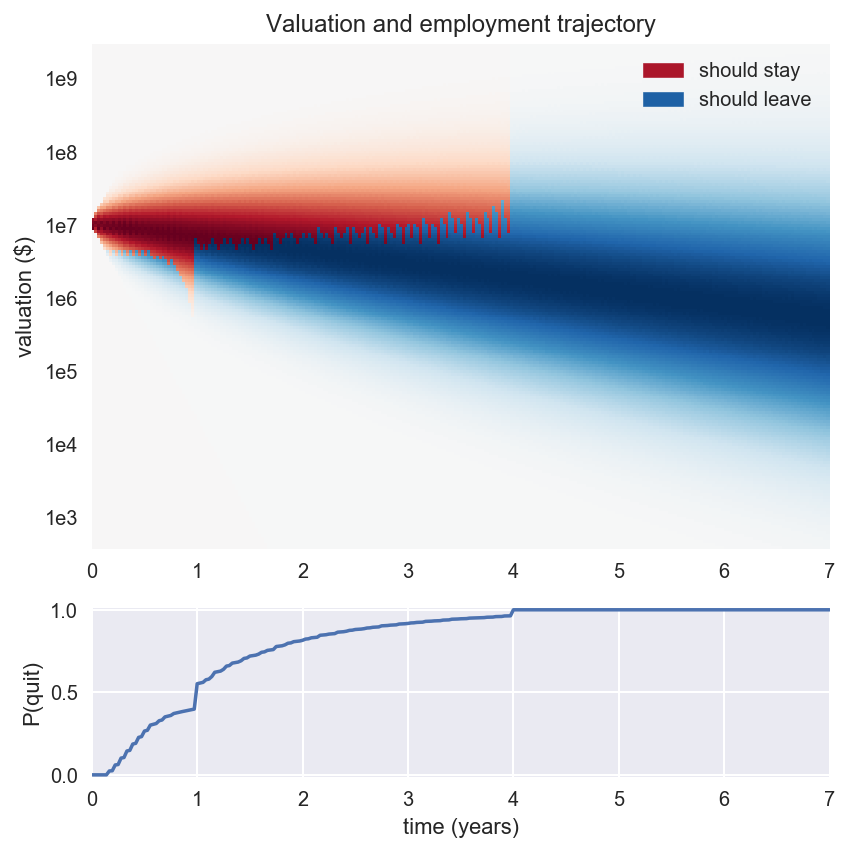

In [26]:
fig = plt.figure(figsize=(6, 6)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 

ax1 = plt.subplot(gs[0])
ax1.set_ylim(0, GRID_NY)
ticks_per_increment = GRID_NY // (LOG_Y_MAX - LOG_Y_MIN)
ylabels = list(reversed(['1e' + str(x//ticks_per_increment + 1)
           if x % ticks_per_increment == 0 else ''
           for x in range(GRID_NY)]))
seaborn.heatmap(grid, yticklabels=ylabels, xticklabels=False, cbar=False, square=True)
plt.ylabel('valuation ($)')
plt.title('Valuation and employment trajectory')
pal = seaborn.color_palette("RdBu_r", 10)
stay = mpatches.Patch(color=pal[-1], label='should stay')
leave = mpatches.Patch(color=pal[0], label='should leave')
plt.legend(handles=[stay, leave])

ax = plt.subplot(gs[1], sharex=ax1)
ax.set_xlim(0, GRID_NX)
ax.xaxis.set_major_locator(ticker.MultipleLocator(model.annual_timesteps))
ax.set_xticklabels(range(-1, 8))
plt.xlabel('time (years)')
plt.ylabel('P(quit)')
ax.set_ylim(-0.01, 1.01)
plt.plot(p_quit.index, p_quit)

plt.tight_layout()